## Traffic sign recognition

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
import sklearn
print(sklearn.__version__)

1.2.1


In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
import keras
print(keras.__version__)

2.15.0


In [6]:
import pandas as pd
print(pd.__version__)

2.1.1


### Import data 

In [7]:
!curl -O https://raw.githubusercontent.com/DJCordhose/buch-machine-learning-notebooks/master/data/speed-limit-signs.zip
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  3131k      0 --:--:-- --:--:-- --:--:-- 3131k


In [8]:
!ls -l speed-limit-signs

total 8
drwxr-xr-x  81 gracialukelo  staff  2592 21 Dez 14:37 0
drwxr-xr-x  83 gracialukelo  staff  2656 21 Dez 14:37 1
drwxr-xr-x  70 gracialukelo  staff  2240 21 Dez 14:37 2
drwxr-xr-x  55 gracialukelo  staff  1760 21 Dez 14:37 3
drwxr-xr-x  43 gracialukelo  staff  1376 21 Dez 14:37 4
drwxr-xr-x  59 gracialukelo  staff  1888 21 Dez 14:37 5
-rw-r--r--   1 gracialukelo  staff   380  6 Jan 22:38 README.md


In [9]:
!cat speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

In [10]:
from skimage.transform import resize

def resize_image(image, target_shape):
    return resize(image, target_shape, mode='reflect', anti_aliasing=True)


In [11]:
import os
from skimage import io
import numpy as np

ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
type = ".ppm"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load its images, resize them to a common shape, and add them to the images list.
    # Also, add the label number (i.e., directory name) to the labels list.
    for f in file_names:
        image = io.imread(f)
        # Resize the image to a common shape (e.g., 64x64). Adjust this size as needed.
        resized_image = resize_image(image, target_shape=(64, 64))
        images.append(resized_image)
        labels.append(int(d))

images, labels = np.array(images), np.array(labels)


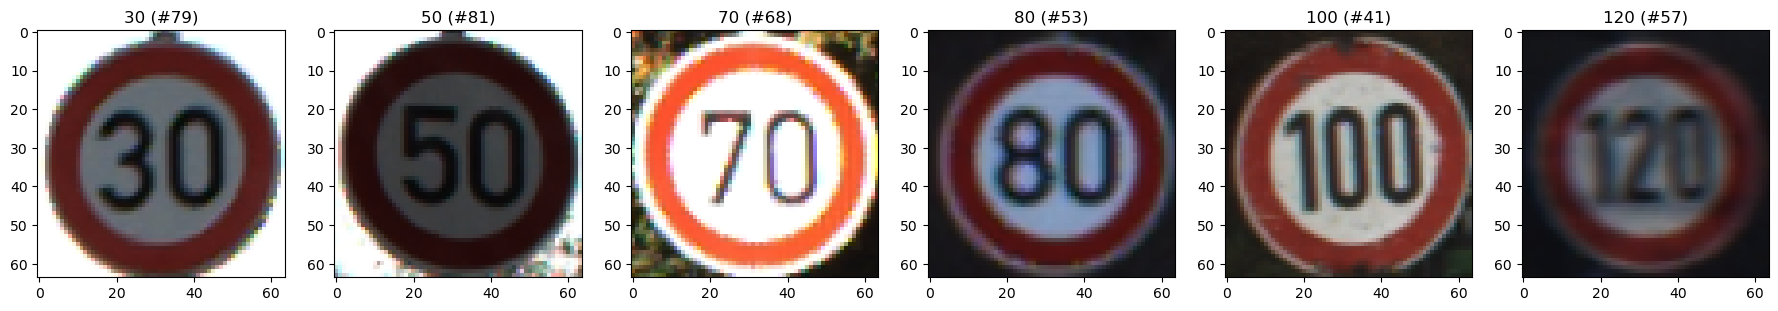

In [12]:
label_names = ['30', '50', '70', '80', '100', '120']

plt.figure(figsize=(30, 15))

unique_values, counts = np.unique(labels, return_counts=True)
classes = len(unique_values)

i = 1
for label in unique_values:
    # Pick the first image for each label.
    image = images[np.where(labels == label)[0][0]]
    plt.subplot(1, 8, i)
    plt.title("{0} (#{1})".format(label_names[label], counts[label]))
    i += 1
    plt.imshow(image)

In [13]:
import skimage.transform

images_64 = np.array([skimage.transform.resize(image, (64, 64)) for image in images])

## Model architecture

In [14]:
X = np.array(images_64)
y = np.array(labels)


# One hot encoding
from keras.utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [15]:
X.shape, y.shape

((379, 64, 64, 3), (379, 6))

In [16]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D


# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [17]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856     
                                                             

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model test

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [20]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [21]:
%time model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
1/1 [==============================] - 1s 685ms/step - loss: 1.7875 - accuracy: 0.1200 - val_loss: 2.4711 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 380ms/step - loss: 1.8068 - accuracy: 0.2800 - val_loss: 1.7189 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 368ms/step - loss: 1.7584 - accuracy: 0.1600 - val_loss: 1.7438 - val_accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 0s 358ms/step - loss: 1.7697 - accuracy: 0.1600 - val_loss: 1.7294 - val_accuracy: 0.2500
Epoch 5/100
1/1 [==============================] - 0s 368ms/step - loss: 1.7431 - accuracy: 0.1600 - val_loss: 1.6966 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 365ms/step - loss: 1.6832 - accuracy: 0.2800 - val_loss: 1.8578 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 370ms/step - loss: 1.6531 - accuracy: 0.2800 - val_loss: 1.8130 - val_accuracy: 0.0000e+

1/1 [==============================] - 0s 358ms/step - loss: 1.6315e-04 - accuracy: 1.0000 - val_loss: 33.8423 - val_accuracy: 0.0833
Epoch 59/100
1/1 [==============================] - 0s 351ms/step - loss: 1.4448e-04 - accuracy: 1.0000 - val_loss: 34.3296 - val_accuracy: 0.0833
Epoch 60/100
1/1 [==============================] - 0s 353ms/step - loss: 1.0013e-04 - accuracy: 1.0000 - val_loss: 34.5836 - val_accuracy: 0.0833
Epoch 61/100
1/1 [==============================] - 0s 370ms/step - loss: 6.0188e-05 - accuracy: 1.0000 - val_loss: 34.6737 - val_accuracy: 0.0833
Epoch 62/100
1/1 [==============================] - 0s 400ms/step - loss: 3.5455e-05 - accuracy: 1.0000 - val_loss: 34.6668 - val_accuracy: 0.0833
Epoch 63/100
1/1 [==============================] - 0s 364ms/step - loss: 2.0816e-05 - accuracy: 1.0000 - val_loss: 34.6109 - val_accuracy: 0.0833
Epoch 64/100
1/1 [==============================] - 0s 385ms/step - loss: 1.2921e-05 - accuracy: 1.0000 - val_loss: 34.5320 - val_a

### Real training

In [22]:
drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [23]:
model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                           

In [24]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# wenn die Ergebnisse sich lange Zeit nicht verbessern, brechen wir lieber ab
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1)

In [27]:
# BATCH_SIZE = 500
BATCH_SIZE = 32
%time model.fit(X_train, y_train, epochs=500, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/500
8/8 [==============================] - 3s 396ms/step - loss: 1.8177 - accuracy: 0.1860 - val_loss: 1.7820 - val_accuracy: 0.1311
Epoch 2/500
8/8 [==============================] - 3s 378ms/step - loss: 1.6851 - accuracy: 0.2149 - val_loss: 1.7844 - val_accuracy: 0.1311
Epoch 3/500
8/8 [==============================] - 3s 381ms/step - loss: 1.7153 - accuracy: 0.2479 - val_loss: 1.7814 - val_accuracy: 0.2131
Epoch 4/500
8/8 [==============================] - 3s 377ms/step - loss: 1.6962 - accuracy: 0.2479 - val_loss: 1.7895 - val_accuracy: 0.1639
Epoch 5/500
8/8 [==============================] - 3s 376ms/step - loss: 1.6999 - accuracy: 0.3099 - val_loss: 1.7714 - val_accuracy: 0.1311
Epoch 6/500
8/8 [==============================] - 3s 384ms/step - loss: 1.6507 - accuracy: 0.2851 - val_loss: 1.7756 - val_accuracy: 0.1639
Epoch 7/500
8/8 [==============================] - 3s 380ms/step - loss: 1.6531 - accuracy: 0.3140 - val_loss: 1.7586 - val_accuracy: 0.1803
Epoch 8/500
8

Epoch 59/500
8/8 [==============================] - 3s 391ms/step - loss: 0.5862 - accuracy: 0.7769 - val_loss: 0.6133 - val_accuracy: 0.8033
Epoch 60/500
8/8 [==============================] - 3s 389ms/step - loss: 0.4360 - accuracy: 0.8471 - val_loss: 0.5146 - val_accuracy: 0.8361
Epoch 61/500
8/8 [==============================] - 3s 388ms/step - loss: 0.5218 - accuracy: 0.8347 - val_loss: 0.5106 - val_accuracy: 0.8033
Epoch 62/500
8/8 [==============================] - 3s 390ms/step - loss: 0.3974 - accuracy: 0.8347 - val_loss: 0.5558 - val_accuracy: 0.8197
Epoch 63/500
8/8 [==============================] - 3s 394ms/step - loss: 0.4030 - accuracy: 0.8512 - val_loss: 0.4243 - val_accuracy: 0.8525
Epoch 64/500
8/8 [==============================] - 3s 391ms/step - loss: 0.3417 - accuracy: 0.8678 - val_loss: 0.5953 - val_accuracy: 0.8033
Epoch 65/500
8/8 [==============================] - 3s 390ms/step - loss: 0.3838 - accuracy: 0.8678 - val_loss: 0.5221 - val_accuracy: 0.8689
Epoch 

8/8 [==============================] - 3s 391ms/step - loss: 0.0575 - accuracy: 0.9793 - val_loss: 0.2361 - val_accuracy: 0.9344
Epoch 117/500
8/8 [==============================] - 3s 383ms/step - loss: 0.0939 - accuracy: 0.9752 - val_loss: 0.2411 - val_accuracy: 0.9508
Epoch 118/500
8/8 [==============================] - 3s 397ms/step - loss: 0.1113 - accuracy: 0.9628 - val_loss: 0.2343 - val_accuracy: 0.9344
Epoch 119/500
8/8 [==============================] - 3s 397ms/step - loss: 0.1106 - accuracy: 0.9669 - val_loss: 0.2706 - val_accuracy: 0.9016
Epoch 120/500
8/8 [==============================] - 3s 386ms/step - loss: 0.2031 - accuracy: 0.9504 - val_loss: 0.1813 - val_accuracy: 0.9508
Epoch 121/500
8/8 [==============================] - 3s 387ms/step - loss: 0.0728 - accuracy: 0.9793 - val_loss: 0.3007 - val_accuracy: 0.9508
Epoch 122/500
8/8 [==============================] - 3s 387ms/step - loss: 0.0731 - accuracy: 0.9793 - val_loss: 0.2486 - val_accuracy: 0.9344
Epoch 123/500

### Bewertung

In [28]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

10/10 [==============================] - 1s 110ms/step - loss: 0.0384 - accuracy: 0.9868


(0.038376759737730026, 0.9867987036705017)

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

3/3 [==============================] - 0s 75ms/step - loss: 0.0603 - accuracy: 0.9605


(0.06034679338335991, 0.9605262875556946)

### Save the model

In [30]:
!rm -r models
!mkdir models

In [31]:
model.save('models/conv-vgg.hdf5')

In [32]:
!ls -lh models

total 112400
-rw-r--r--  1 gracialukelo  staff    55M  6 Jan 22:49 conv-vgg.hdf5


In [33]:
# so lädt man das komplette Modell wieder in den Speicher
new_model = tf.keras.models.load_model('models/conv-vgg.hdf5')

### Ausprobieren auf ein paar Test-Daten

In [34]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

1/1 [==============================] - 0s 83ms/step


array([5, 2, 0, 5, 0, 5, 2, 1, 0, 5])

In [35]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

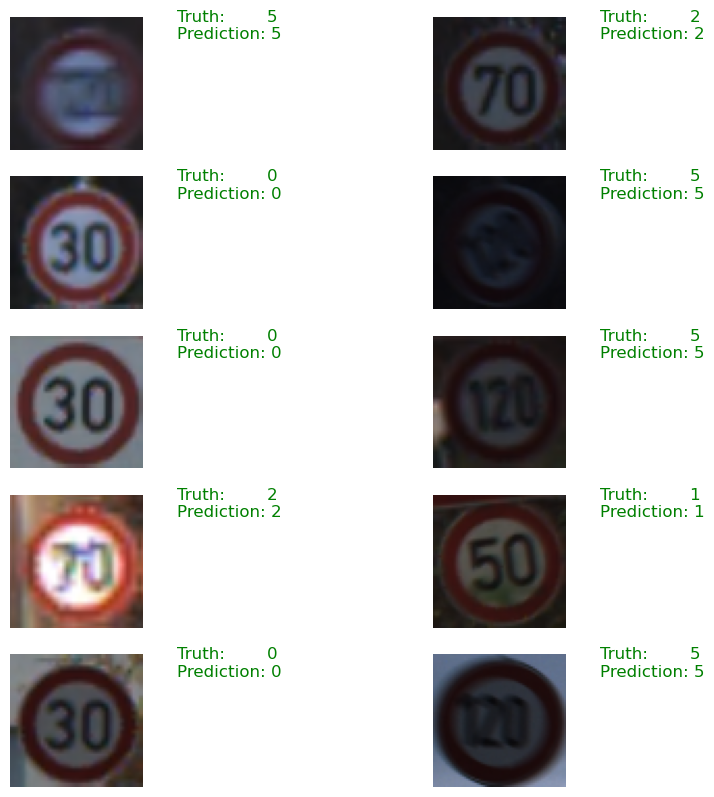

In [36]:
display_prediction(sample_images, ground_truth, predicted_categories)